In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Dropout, LSTM, BatchNormalization
from tensorflow.keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
from sklearn.model_selection import train_test_split
import re
nltk.download('stopwords')
decode_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def decode_sentiment(label):
    return decode_map[int(label)]
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SEQUENCE_LENGTH = 150
SENTIMENT_THRESHOLDS = (0.4, 0.6)
TRAIN_SIZE=0.55
EPOCHS = 8
BATCH_SIZE = 64
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('news_classed.csv')
df.dropna(inplace=True)
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
df.text = df.text.apply(lambda x: preprocess(x))
df.target = df.target.apply(lambda x: decode_sentiment(x))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
counts = dict(Counter(df_train.target))
print(counts)

TRAIN size: 5924
TEST size: 1481
{'NEUTRAL': 3907, 'POSITIVE': 987, 'NEGATIVE': 1030}


In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip -q install gensim --upgrade
!rm -r sample_data
!kaggle datasets download rtatman/glove-global-vectors-for-word-representation
!unzip -q glove-global-vectors-for-word-representation

     |████████████████████████████████| 24.2MB 164kB/s 
 97% 446M/458M [00:04<00:00, 104MB/s] 
100% 458M/458M [00:04<00:00, 99.1MB/s]


In [9]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.200d.txt", word2vec_output_file="model.w2v")
w2v_model = KeyedVectors.load_word2vec_format('model.w2v')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [10]:
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 2
W2V_MIN_COUNT = 10

words = w2v_model.wv.vocab.keys()
vocab_size = len(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [0]:
import pickle

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
'''
with open('tokenizer_stock.pkl','rb') as f:
  tokenizer = pickle.load(f)
'''
vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [12]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5924, 150)
y_train (5924, 1)

x_test (1481, 150)
y_test (1481, 1)


In [13]:
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
from tensorflow.keras.optimizers import Adam, Nadam

for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(70, dropout=0.3, recurrent_dropout=0.3)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-15),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          3333600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 200)          240800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 200)          800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140)               151760    
_________________________________________________________________
batch_normalization_3 (Batch (None, 140)               560       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [0]:
from tensorflow.keras.models import load_model
model = load_model('news_model_stock.h5')

In [16]:
history=model.fit(x_train,y_train,batch_size=20,epochs=50,validation_split=0.2)

Epoch 1/50
237/237 [==============================] - 274s 1s/step - loss: 1.5930 - accuracy: 0.3210 - val_loss: 1.2751 - val_accuracy: 0.2110
Epoch 2/50
237/237 [==============================] - 271s 1s/step - loss: 1.5712 - accuracy: 0.3212 - val_loss: 1.4089 - val_accuracy: 0.2574
Epoch 3/50
237/237 [==============================] - 273s 1s/step - loss: 1.5785 - accuracy: 0.3239 - val_loss: 1.4020 - val_accuracy: 0.2785
Epoch 4/50
237/237 [==============================] - 273s 1s/step - loss: 1.5980 - accuracy: 0.3096 - val_loss: 1.3844 - val_accuracy: 0.2827
Epoch 5/50
237/237 [==============================] - 276s 1s/step - loss: 1.5893 - accuracy: 0.3180 - val_loss: 1.4018 - val_accuracy: 0.2835
Epoch 6/50
237/237 [==============================] - 273s 1s/step - loss: 1.5820 - accuracy: 0.3197 - val_loss: 1.4003 - val_accuracy: 0.2819
Epoch 7/50
237/237 [==============================] - 275s 1s/step - loss: 1.5787 - accuracy: 0.3243 - val_loss: 1.3874 - val_accuracy: 0.2844

In [19]:
from tensorflow.keras.models import load_model
#model = load_model('news_model_stock.h5')
#model.evaluate(x_test,y_test)
one_good = 0
one_bad = 0
two_good=0
two_bad=0
good = 0
bad=0
for i,j in zip(x_test,y_test):
  true = j[0]
  predict = np.argmax(model.predict(np.array([i])))
  print(j)
  if true == 0:
    if predict == 0:
      good+=1
    else:
      bad +=1
  elif true == 1:
    if predict == 1:
      one_good+=1
    else:
      one_bad+=1
  else:
    if predict == 2:
      two_good+=1
    else:
      two_bad+=1
print(good,bad)
print(one_good,one_bad)
print(two_good,two_bad)

[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


KeyboardInterrupt: ignored

In [26]:
from collections import Counter
y = [i[0] for i in y_test]
print(Counter(y))

Counter({1: 395, 0: 387})


In [0]:
model.save('news_model_stock.h5')

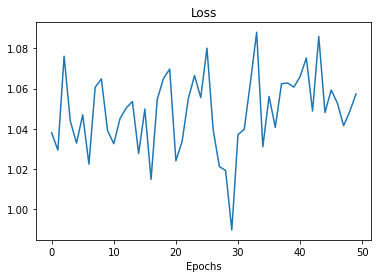

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()